In [1]:
%load_ext autoreload

%autoreload 2
import sys
import os
import clmm

import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
from clmm.clusterensemble import ClusterEnsemble
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
import numpy as np
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from numpy import random
import chainconsumer
import scipy

clmm.__version__

'1.0.4'

In [2]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
from scipy.optimize import curve_fit

In [3]:
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(cosmo)

In [4]:
z_bin = [0.2,0.25]
logm_bin = [14, 14.1] #Solar Mass
logm_bin = np.array(logm_bin)
n_catalogs = 50
ngals = 10000
cluster_m = 10**((logm_bin[1] - logm_bin[0])*np.random.random(n_catalogs) + logm_bin[0]) #in M_sun
cluster_z = (z_bin[1] - z_bin[0])*np.random.random(n_catalogs) + z_bin[0]
lnc = abs(np.log(4) + 0.1*np.random.randn(n_catalogs))
ra = np.random.random(n_catalogs)*(360 + 0) - 0 #from 0 to 360 deg
sindec = np.random.random(n_catalogs)*(1 + 1) - 1
dec = np.arcsin(sindec)*180/np.pi #from -90 to 90 deg
concentration = np.exp(lnc)

### Generating a list of individual background galaxy catalogs

In [5]:
gclist = []
for i in range(n_catalogs):
    noisy_data_z = mock.generate_galaxy_catalog(cluster_m[i], cluster_z[i], concentration[i], 
                                                    cosmo, 
                                                    zsrc = 'chang13', 
                                                    #Delta_SO=200, 
                                                    massdef='critical',
                                                    halo_profile_model='nfw', 
                                                    zsrc_min=cluster_z[i] + 0.1,
                                                    zsrc_max=3., 
                                                    field_size=10., 
                                                    shapenoise=.003, 
                                                    photoz_sigma_unscaled=0.0, 
                                                    ngals=ngals)
    cl = clmm.GalaxyCluster('mock_cluster', 0, 0, cluster_z[i], noisy_data_z)
    cl.compute_tangential_and_cross_components(geometry="flat",
                                              shape_component1='e1', shape_component2='e2', 
                                              tan_component='et', cross_component='ex',
                                              add=True, 
                                              is_deltasigma = False, 
                                              cosmo = cosmo)
    cl.ra, cl.dec = ra[i], dec[i]
    cl.galcat['R'] = cosmo.eval_da_z1z2(0,cluster_z[i])*cl.galcat['theta']
    cl.galcat['w_ls'] = 1/cosmo.eval_sigma_crit(cluster_z[i], cl.galcat['ztrue'])**2
    ang, phi = clmm.dataops._compute_lensing_angles_flatsky(cl.ra, cl.dec, cl.galcat['ra'], cl.galcat['dec'])
    cl.galcat['phi'] = np.array(phi)
    cl.galcat['sigma_c_true'] = cosmo.eval_sigma_crit(cluster_z[i], cl.galcat['ztrue'])
    cl.id = i
    cl.galcat['st'] = cl.galcat['sigma_c_true']*cl.galcat['et']
    cl.galcat['sx'] = cl.galcat['sigma_c_true']*cl.galcat['ex']
    gclist.append(cl)

/pbs/throng/lsst/users/cpayerne/CLMM/clmm/dataops/__init__.py:198: UserWarning: Using the flat-sky approximation with separations >1 deg may be inaccurate
  "Using the flat-sky approximation with separations >1 deg may be inaccurate")


## Creating ClusterEnsemble object

In [6]:
ensemble_id = 1
names = ['id', 'ra', 'dec', 'z', 'r', 'gt', 'gx', 'W_l']
bins = np.logspace(np.log10(0.3),np.log10(5),20)
clusterensemble = ClusterEnsemble(ensemble_id, names, gclist, tan_component='st',
    cross_component='sx', sep='R', weights = 'w_ls', bins = bins)

### Stacked data

In [8]:
stacked_data = clusterensemble.data
r_stack, gt_stack, gx_stack = clusterensemble.make_stacked_radial_profile(stacked_data)

### Covariance

In [13]:
clusterensemble.compute_sample_covariance(stacked_data)
clusterensemble.compute_bootstrap_covariance(stacked_data, n_bootstrap=100)
clusterensemble.compute_jackknife_covariance(stacked_data, n_side=4)

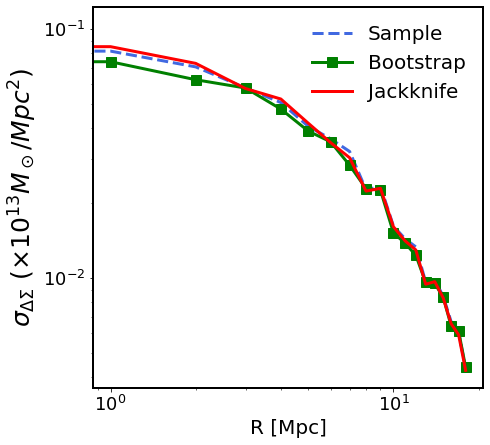

In [14]:
plt.figure(figsize = (7,7))
plt.rcParams['axes.linewidth'] = 2
plt.plot(clusterensemble.sample_tangential_covariance_matrix.diagonal()**0.5/1e13,'--',c = 'royalblue', label = 'Sample', linewidth = 3)
plt.plot(clusterensemble.bootstrap_tangential_covariance_matrix.diagonal()**0.5/1e13,'-s',c = 'g', label = 'Bootstrap', linewidth = 3, markersize = 10)
plt.plot(clusterensemble.jackknife_tangential_covariance_matrix.diagonal()**0.5/1e13,c = 'r', label = 'Jackknife', linewidth = 3)
plt.xlabel('R [Mpc]', fontsize =20)
plt.ylabel(r'$\sigma_{\Delta\Sigma}\ (\times 10^{13} M_\odot /Mpc^2)$', fontsize =25)
plt.tick_params(axis='both', which = 'major', labelsize= 18)
plt.legend(frameon = False, fontsize = 20)
plt.loglog()
plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/sprint_week_cov.png', bbox_inches='tight', dpi=300)

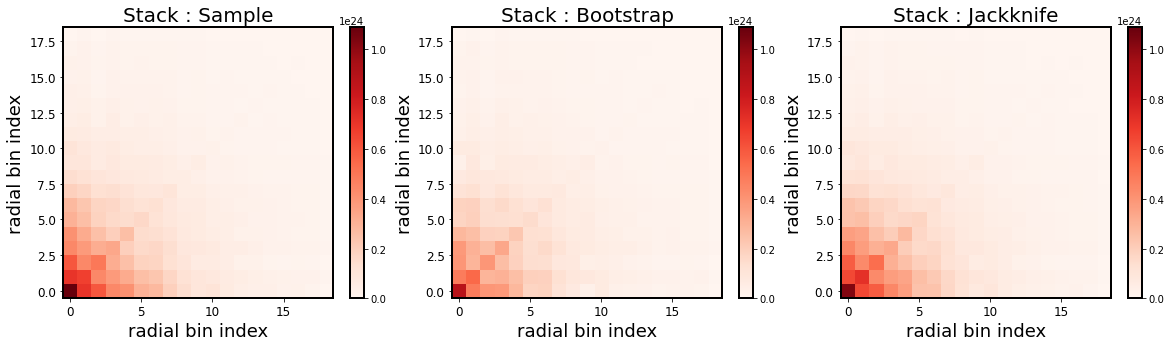

In [15]:
fig, ax = plt.subplots(1,3, figsize =(20, 5))
plt.rcParams['axes.linewidth'] = 2
fig.subplots_adjust(wspace=0.15, hspace=0)
cov = [clusterensemble.sample_tangential_covariance_matrix, 
       clusterensemble.bootstrap_tangential_covariance_matrix,
      clusterensemble.jackknife_tangential_covariance_matrix,]
maximum = max(clusterensemble.sample_tangential_covariance_matrix.flatten())
label = ['Stack : Sample', 'Stack : Bootstrap', 'Stack : Jackknife']
for i in range(3):
    ax[i].set_title(label[i], fontsize = 20)
    ax[i].set_xlabel('radial bin index', fontsize = 18)
    ax[i].set_ylabel('radial bin index', fontsize = 18)
    ax[i].tick_params(axis='both', which = 'major', labelsize= 12)
    im = ax[i].imshow(cov[i], cmap = 'Reds',vmin = 0, vmax = maximum, origin = 'low')
    plt.colorbar(im, ax=ax[i])
plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/sprint_week_cov_full.png', bbox_inches='tight', dpi=300)

(-2.0, 2.0)

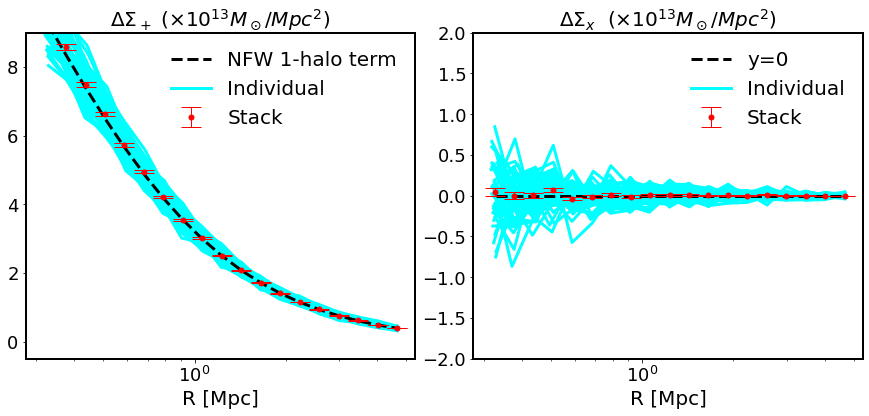

In [16]:
plt.rcParams['axes.linewidth'] = 2
fig, axs = plt.subplots(1,2, figsize = (15,6), sharex = True)
fig.subplots_adjust(wspace=0.15, hspace=0)
err_gt = clusterensemble.sample_tangential_covariance_matrix.diagonal()**0.5/1e13
err_gx = clusterensemble.sample_cross_covariance_matrix.diagonal()**0.5/1e13
axs[0].errorbar(r_stack,gt_stack/1e13, err_gt,markersize = 5, c = 'r', fmt = 'o', capsize = 10, elinewidth = 1, zorder = 1000, alpha = 1, label = 'Stack')
axs[1].errorbar(r_stack,gx_stack/1e13, err_gx,markersize = 5, c = 'r', fmt = 'o', capsize = 10, elinewidth = 1, zorder = 1000, alpha = 1, label = 'Stack')
moo.set_concentration(concentration.mean())
moo.set_mass(cluster_m.mean())
axs[0].plot(clusterensemble.data['r'][0],moo.eval_excess_surface_density(clusterensemble.data['r'][0], cluster_z.mean())/1e13, '--k', linewidth = 3, label = 'NFW 1-halo term', zorder = 100)
axs[1].plot(clusterensemble.data['r'][0],0*moo.eval_excess_surface_density(clusterensemble.data['r'][0], cluster_z.mean())/1e13, '--k', linewidth = 3, label = 'y=0', zorder = 100)
axs[0].set_xscale('log')
for i in range(n_catalogs):
    axs[0].plot(clusterensemble.data['r'][i],clusterensemble.data['gt'][i]/1e13, 'cyan', label = 'Individual', alpha = 1, linewidth = 3)
    axs[1].plot(clusterensemble.data['r'][i],clusterensemble.data['gx'][i]/1e13, 'cyan', label = 'Individual', alpha = 1, linewidth = 3)
    if i == 0:
        axs[0].legend(frameon = False, fontsize = 20)
        axs[1].legend(frameon = False, fontsize = 20)
axs[0].set_xlabel('R [Mpc]', fontsize =20)
axs[1].set_xlabel('R [Mpc]', fontsize =20)
axs[0].tick_params(axis='both', which = 'major', labelsize= 18)
axs[1].tick_params(axis='both', which = 'major', labelsize= 18)
axs[0].set_title(r'$\Delta\Sigma_+$ $(\times 10^{13} M_\odot /Mpc^2)$', fontsize= 20)
axs[1].set_title(r'$\Delta\Sigma_x$  $(\times 10^{13} M_\odot /Mpc^2)$', fontsize= 20)
axs[0].set_ylim(-.5,9)
axs[1].set_ylim(-2,2)
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/sprint_week_stack.png', bbox_inches='tight', dpi=300)